# Guide for twinpy/analysis/twinboundary_analyzer.py

In [1]:
%aiida
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
from pprint import pprint
from matplotlib import pyplot as plt
import twinpy
from twinpy.interfaces.aiida import (AiidaVaspWorkChain,
                                     AiidaRelaxWorkChain,
                                     AiidaPhonopyWorkChain,
                                     AiidaShearWorkChain,
                                     AiidaTwinBoudnaryRelaxWorkChain,
                                     )
from twinpy.analysis.twinboundary_analyzer import TwinBoundaryAnalyzer
from twinpy.file_io import write_thermal_ellipsoid

jupyter_dir = os.path.join(os.path.dirname(twinpy.__file__), '..', 'jupyter')
sys.path.append(os.path.join(jupyter_dir, 'site-packages'))
from jupyter_help import show_info

bulk_phonon_pk = 289856  # twinpy
twinboundary_pk = 186343  # twinpy
additional_relax_pks = [267977, 279276, 282215, 283951]   # twinpy
twinboundary_phonon_pk = 286877  # twinpy
twinboundary_shear_relax_pks = [297874, 297890, 297907, 297924]
twinboundary_shear_phonon_pks = [299318, 300184, 300580, 300760]

# class TwinBoundaryAnalyzer

In [4]:
aiida_tb = AiidaTwinBoudnaryRelaxWorkChain(load_node(twinboundary_pk))
aiida_tb.set_additional_relax(aiida_relax_pks=additional_relax_pks)
phonons = []
for pk in (bulk_phonon_pk, twinboundary_phonon_pk):
    aiida_phonon = AiidaPhonopyWorkChain(load_node(pk))
    phonons.append(aiida_phonon.get_phonon())
analyzer = TwinBoundaryAnalyzer(
    twinboundary_structure=aiida_tb.twinpy.twinboundary,
    hexagonal_phonon=phonons[0],
    twinboundary_phonon=phonons[1])
show_info(analyzer, is_class=True)

NameError: name 'std' is not defined

## def set_shear_phonons

In [31]:
show_info(analyzer.set_shears)
shear_relaxes = [ AiidaRelaxWorkChain(load_node(pk))
                      for pk in twinboundary_shear_relax_pks ]
shear_phonons = [ AiidaPhonopyWorkChain(load_node(pk))
                      for pk in twinboundary_shear_phonon_pks ]
analyzer.set_shears(shear_relaxes=shear_relaxes,
                    shear_phonons=shear_phonons)
print("# shear relaxes")
pprint(analyzer.shear_relaxes)
print("")
print("# shear phonons")
pprint(analyzer.shear_phonons)

====== START method information ======

# ---------
# docstring
# ---------

        Set shear relaxes and corresponding shear phonons

        Args:
            shear_relaxes: list of AiidaRelaxWorkChain
            shear_phonons: list of AiidaPhonopyWorkChain
        

======= END method information =======


# shear relaxes

# shear phonons


In [5]:
analyzer.run_mesh(interval=0.04)
# tdms = analyzer.get_thermal_displacement_matrices()
tdms_orig_no_shift = analyzer.get_thermal_displacement_matrices(with_original_cart=True)

run mesh with [57 57 32] (hexagonal)
run mesh with [50  4 22] (twinboundary)


KeyboardInterrupt: 

In [ ]:
temp = [0, 50, 100, 150, 200, 250, 300]
header = os.path.join('/home', 'mizo', 'test', 'Mg_10-12_')
write_thermal_ellipsoid(
    cell=analyzer.twinboundary_structure.get_cell_for_export(),
    matrices=tdms_orig_no_shift[1],
    temperatures=temp,
    header=header)

In [379]:
analyzer.run_mesh(interval=0.35)
# tdms = analyzer.get_thermal_displacement_matrices()
tdms_orig = analyzer.get_thermal_displacement_matrices(with_original_cart=True)

run mesh with [65 65 36] offset (0.0, 0.0, 0.5) (hexagonal)
run mesh with [56  4 24] offset (0.5, 0.5, 0.5) (twinboundary)


In [346]:
# print(tdms_orig[0][5])
# print(tdms_orig[1][5])
tdms = analyzer.get_thermal_displacement_matrices(with_original_cart=False)

In [361]:
# rot = analyzer.hexagonal_to_original_rotation_matrix
# tdms[0].thermal_displacement_matrices.shape
# print(tdms_orig[0][5])
# print(tdms_orig[1][5])
# tdms_orig[0][6]
rot = analyzer.hexagonal_to_original_rotation_matrix
# tdms[0][6]
print(tdms[0][6])
# a = np.dot(rot, np.dot(tdms_orig[0][6,0], rot.T))
# np.dot(rot.T, np.dot(a, rot))
# tdms_orig[0][6, 0]

[[[ 1.50434791e-02 -2.75468256e-12  2.10503716e-13]
  [-2.75468256e-12  1.50434791e-02  5.04605639e-12]
  [ 2.10503716e-13  5.04605639e-12  1.10895303e-01]]

 [[ 1.50434791e-02  4.15138207e-11  2.10510598e-13]
  [ 4.15138207e-11  1.50434791e-02  5.04610955e-12]
  [ 2.10510598e-13  5.04610955e-12  1.10895303e-01]]]


In [11]:
print("# exagonal to original rotation matrix")
pprint(analyzer.hexagonal_to_original_rotation_matrix)
print("")
print("# twinboundary to original rotation matrix")
pprint(analyzer.twinboundary_to_original_rotation_matrix)

# exagonal to original rotation matrix
array([[ 0.5       , -0.8660254 ,  0.        ],
       [ 0.63228188,  0.36504811,  0.68334435],
       [-0.59179357, -0.34167217,  0.73009622]])

# twinboundary to original rotation matrix
array([[ 1.00000000e+00,  8.84117822e-17, -7.06153663e-10],
       [-7.06153663e-10, -6.24323039e-26, -1.00000000e+00],
       [-8.84117822e-17,  1.00000000e+00,  0.00000000e+00]])


In [12]:
t = 5
j, k = 2, 2
cell = analyzer.twinboundary_structure.get_cell_for_export()
y = list(cell[1][:,2])
x_s = tdms_orig_no_shift[1][t,:]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x_s[:,j,k], y)

# bulk_cell = analyzer.hexagonal_structure.get_cell_for_export()
bulk_y = [0.25, 0.75]
bulk_x_s = tdms_orig_no_shift[0][t,:]
ax.scatter(bulk_x_s[:,j,k], bulk_y, c='r')

NameError: name 'tdms_orig_no_shift' is not defined

In [13]:

write_thermal_ellipsoid(Oh)
tdms_orig_no_shift

NameError: name 'Oh' is not defined

In [14]:
print("# label")
print(aiida_twinboundary_relax.label)
print("")
print("# description")
print(aiida_twinboundary_relax.description)
print("")
print("# twinboundary relax settings")
pprint(aiida_twinboundary_relax.twinboundary_settings)
print("")
print("# get pks")
pprint(aiida_twinboundary_relax.get_pks())
print("")
print("# structure diff")
pprint(aiida_twinboundary_relax.get_diff().keys())
print("")

analyzer.hexagonal_to_original_rotation_matrix

# label


NameError: name 'aiida_twinboundary_relax' is not defined

## set additional relax

In [15]:
aiida_twinboundary_relax.set_additional_relax(twinboundary_relax_additional_relax_pk)
print("# get pks")
pprint(aiida_twinboundary_relax.get_pks())

NameError: name 'aiida_twinboundary_relax' is not defined

## get_planes_angles

In [33]:
pprint(aiida_twinboundary_relax.get_planes_angles(
    is_fractional=True,
    get_additional_relax=True))

{'angles': {'before': array([ 0.        , 11.43304902, 11.43304902, 11.43304902, 11.43304902,
       11.43304902, 11.43304902, 11.43304902, 11.43304902, 11.43304902,
       11.43304902,  0.        , 11.43304902, 11.43304902, 11.43304902,
       11.43304902, 11.43304902, 11.43304902, 11.43304902, 11.43304902,
       11.43304902, 11.43304902]),
            'relax': array([ 0.        , 10.6076032 ,  9.00754571, 11.01664803, 11.13948968,
       11.15799793, 11.15799793, 11.13948968, 11.01664803,  9.00754571,
       10.6076032 ,  0.        , 10.6076032 ,  9.00754571, 11.01664803,
       11.13948968, 11.15799793, 11.15799793, 11.13948968, 11.01664803,
        9.00754571, 10.6076032 ])},
 'planes': {'before': [0.0,
                       0.04545454995602156,
                       0.09090908998538572,
                       0.1363636399414073,
                       0.18181819013954245,
                       0.2272727200001356,
                       0.27272726995615715,
                    

## get_distances

In [34]:
pprint(aiida_twinboundary_relax.get_distances(
    is_fractional=True,
    get_additional_relax=True))

{'before': [0.04545454995602156,
            0.04545454002936416,
            0.04545454995602158,
            0.04545455019813516,
            0.045454529860593146,
            0.04545454995602155,
            0.04545454995602155,
            0.045454540029364165,
            0.04545455019813516,
            0.045454549956021606,
            0.04545454002936411,
            0.04545453978725056,
            0.04545455019813516,
            0.045454549956021606,
            0.04545454002936411,
            0.045454549956021606,
            0.045454549956021606,
            0.045454530102706614,
            0.045454549956021606,
            0.04545454995602172,
            0.045454540029364,
            0.04545454994800768],
 'relax': [0.04600357499443968,
           0.044887965120733876,
           0.04575543485303413,
           0.04514417508303595,
           0.04549897485360674,
           0.045419750190299396,
           0.04549897485360671,
           0.045144175083035976,
        

## plane diff

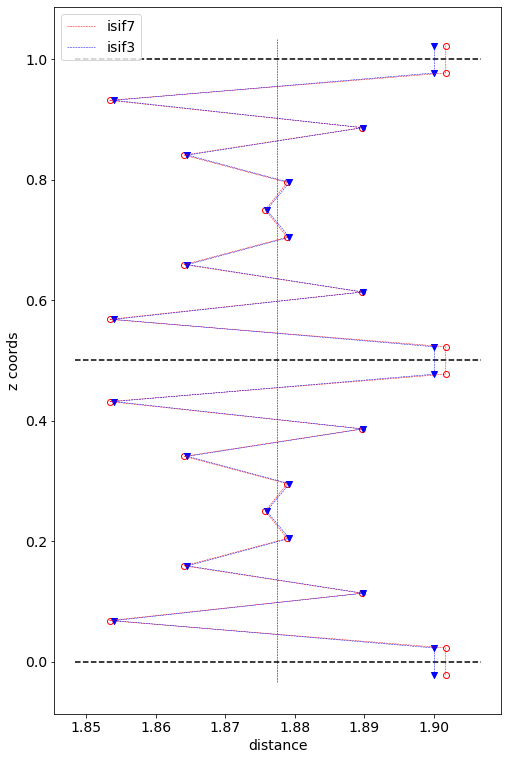

In [36]:
aiida_twinboundary_relax.plot_plane_diff(
           is_fractional=True,
           is_decorate=True)

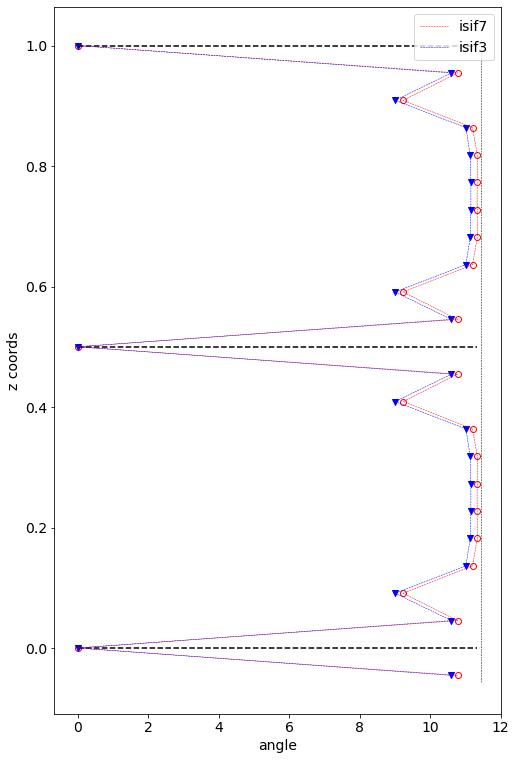

In [37]:
aiida_twinboundary_relax.plot_angle_diff(
           is_fractional=True,
           is_decorate=True)

## formation energy

In [40]:
aiida_twinboundary_relax.get_formation_energy(bulk_relax_pk=bulk_relax_pk)

139.1241761281626